# Power Outages
This project uses major power outage data in the continental U.S. from January 2000 to July 2016. Here, a major power  outage is defined as a power outage that impacted at least 50,000 customers or caused an unplanned firm load loss of atleast 300MW. Interesting questions to consider include:
- Where and when do major power outages tend to occur?
- What are the characteristics of major power outages with higher severity? Variables to consider include location, time, climate, land-use characteristics, electricity consumption patterns, economic characteristics, etc. What risk factors may an energy company want to look into when predicting the location and severity of its next major power outage?
- What characteristics are associated with each category of cause?
- How have characteristics of major power outages changed over time? Is there a clear trend?

### Getting the Data
The data is downloadable [here](https://engineering.purdue.edu/LASCI/research-data/outages/outagerisks).

A data dictionary is available at this [article](https://www.sciencedirect.com/science/article/pii/S2352340918307182) under *Table 1. Variable descriptions*.

### Cleaning and EDA
- Note that the data is given as an Excel file rather than a CSV. Open the data in Excel or another spreadsheet application and determine which rows and columns of the Excel spreadsheet should be ignored when loading the data in pandas.
- Clean the data.
    - The power outage start date and time is given by `OUTAGE.START.DATE` and `OUTAGE.START.TIME`. It would be preferable if these two columns were combined into one datetime column. Combine `OUTAGE.START.DATE` and `OUTAGE.START.TIME` into a new datetime column called `OUTAGE.START`. Similarly, combine `OUTAGE.RESTORATION.DATE` and `OUTAGE.RESTORATION.TIME` into a new datetime column called `OUTAGE.RESTORATION`.
- Understand the data in ways relevant to your question using univariate and bivariate analysis of the data as well as aggregations.

*Hint 1: pandas can load multiple filetypes: `pd.read_csv`, `pd.read_excel`, `pd.read_html`, `pd.read_json`, etc.*

*Hint 2: `pd.to_datetime` and `pd.to_timedelta` will be useful here.*

*Tip: To visualize geospatial data, consider [Folium](https://python-visualization.github.io/folium/) or another geospatial plotting library.*

### Assessment of Missingness
- Assess the missingness of a column that is not missing by  design.

### Hypothesis Test
Find a hypothesis test to perform. You can use the questions at the top of the notebook for inspiration.

# Summary of Findings

### Introduction
In this project, we explore a dataset containing information about power outages across the states. Specifically, we look into number of outages per state and why these are occuring, looking for solutions that would be useful for electrical companies to apply. We also discover univariate and bivariate statistical analysis to extract other types of information from our dataset, such as mean outage times per category, their category details and if these are preventable outages or not (and why). Our goal is to form an analysis to show why these outages are occuring and how we can prevent future ones. We also examine the dataset itself, checking for missingness and doing hypothesis tests to see if one state has more outages than average than other states, and why this might be (is it fixable, or due to factors out of our control?). 

### Cleaning and EDA
This dataset is given in a format unable to be manipulated without a bit of data cleaning. A column for variables, observations, units for each column, and more is included in the dataset's rows. In order to solve this issue, we reformat the dataset to only contain actual data, and remove any unnessessary columns or rows. 
We also reformat the date and time columns to be one column containing both the date and time, and turn them into datetime objects for the sake of data manipulation due. We also convert columns that are objects that should be ints or floats into floats, for the purpose of being able to do statistical analyses on them due to some columns having null values. 
For exploratory data analysis, we explored the most common category cause per state, focusing on if these are preventable causes or not, with weather being unpreventable. We also explored the states that suffered the most outages, as well as the highest outage durations. We plotted next to this the population of the state to see if there are any abnormalities, where we discovered Wisconsin to have a higher average outage duration despite not having the most reports. We also explored some of the columns, discovering that most outages happen in the middle of winter or summer (presumably due to winter and summer storms). We also discovered that this data has more reports in 2010 than any other year present in the dataset. 
This method of bivariate analysis also helped us to identify common outage categories per state. Washington and Utah, for example, suffer a lot from Vandalism, which is an intentional attack. 
Some of the category details overlap, as well, with storms, winter storms, ice/snow storms, and more. However, for the sake of keeping these details seperate, we did not combine these, since they may have different meanings to the electrical company.
### Assessment of Missingness
For the follow assessments, we use a signifigance level of .05. 

DEPDENDENCE: We chose to evaluate the column CUSTOMERS.AFFECTED that details the number of customers affected by the power outage. When determining if this column was NMAR, we compared it to the column CAUSE.CATEGORY that has no null values. We found that most of the values that were null or 0 in CUSTOMERS.AFFECTED occured when CAUSE.CATEGORY was an intentional attack. Thus, CUSTOMERS.AFFECTED could be dependent on the CAUSE.CATEGORY. We ran a permutation test using total variation distance as our test statistic because we are running this against a categorical column. When running this simulation 1000 times, we get a pvalue of 0.00, meaning that CUSTOMERS.AFFECTED is MAR depedent on CAUSE.CATEGORY, since the distributions are not the same when shuffling.

NONDEPENDENT: When it came to checking for a column that was not dependent, it was easily spotted that ANOMALY.LEVEL had NaN values randomly scattered throughout the column. ANOMALY.LEVEL represents the oceanic El Nino/La Nina index, which is based on cold and warm episodes during a season. We investigated if U.S._STATE had anything to do with the missingness of ANOMALY.LEVEL, with the assumption that it should not have a dependent relationship like CLIMATE.REGION would, for example. To do this, we set up a permutation test to compare the total variation distance between the null values of ANOMALY.LEVEL and the shuffled and non shuffled column of U.S._STATE. After running this simulation and calculating the pvalue 1000 times, we get a pvalue of .524, meaning that there is no dependance on the U.S._STATE column due to it being above our signifigance level.  

### Hypothesis Test
Null Hypothesis: Wisconsin has the same length power outages as other states on average.
Alternative: Wisconsin has longer power outages than other states on average. 
While looking at the data we noticed that Wisconsin had the longest power outages on average of any state. Too discover whether this was a result of chance or a result of some other factor we decided to do a hypothesis test. We created are null hypothesis to state that on average Wisconsin has the same length of power outages as other states. Our alternative hypothesis stated that on average Wisconsin has longer power outages than other states. To determine whether we could reject the null hypothesis we decided our test statistic should be the mean length of power outages for the states and set our significance level to be .05. We ran a hypothesis test where we found 1000 test statistics which we used to create a distribution of what the length of power outages was on average. We ended up finding a p-value of .005 so we had sufficient evidence to reject the null hypothesis and accept the validity of our alternative hypothesis. This test was useful because we were able to prove that Wisconsin’s power outages are longer than other states for a reason besides chance.

# Code

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import folium #for geospatial analysis
import seaborn as sns
from IPython.display import Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Cleaning and EDA

Before we start, we must alter the dataframe to be something we can work with. This data frame in particular has variables, indexes (called OBS) and units included within the CSV mixing with the actual data we want to explore. We can set the variable names, extract the units, and reset the index to extract all of the information we want.
Next, we reformat the dataset to have the start/end date and time in one column, and converted to datetime objects for easier manipulation. We do this by combining the columns, converting them to datetime objects, and reassigning the dataframe to only contain the new datetime columns, removing the old ones.
We also can add a column that contains the total outage time of a specific report. We can use this later in our analysis. Lastly, we turn variables that are objects into floats so we can do statistical analyses on them. 

In [73]:
#Read in CSV file
df = pd.read_csv('outage.csv')
#Check for format
df.head(6)

,Major power outage events in the continental U.S.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56
0,Time period: January 2000 - July 2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Regions affected: Outages reported in this dat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,variables,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
5,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,numeric,NaN,...,%,%,persons per square mile,persons per square mile,persons per square mile,%,%,%,%,%


In [74]:
#Set the columsn to the variables
df.columns = df.loc[4]
#Keep the units in an accessible list in case we need it
units = df.loc[5][1:]
#Drop the rows and columns that we do not need
df = df.drop([0,1,2,3,4,5]).drop(columns = ['variables']).reset_index(drop = True)

#CODE FOR TIME CONVERSION 
#Combine the date and times into one column
df['OUTAGE.START'] = df['OUTAGE.START.DATE']+" "+df['OUTAGE.START.TIME']
df['OUTAGE.RESTORATION'] = df['OUTAGE.RESTORATION.DATE']+" "+df['OUTAGE.RESTORATION.TIME']

#Convert these columns to datetime objects
df['OUTAGE.START'] = pd.to_datetime(df['OUTAGE.START'])
df['OUTAGE.RESTORATION'] = pd.to_datetime(df['OUTAGE.RESTORATION'])

#We can now drop the orginial columns since we have no use for them 
df = df.drop(columns = ['OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE','OUTAGE.RESTORATION.TIME' ])

#HELPER FUNCTIONS
#Define a function that calculates total time
def subtract(row):
    return row[1]-row[0]

#Grab the columns we need
temp = df[['OUTAGE.START', 'OUTAGE.RESTORATION']]
#Apply the helper to the new total time of outage column
df['OUTAGE.TIME'] = temp.apply(lambda x : x[1] - x[0],axis=1)

#Helper function to convert variables to floats for later manipulation
def convert(x):
    if x != x:
        return x
    try:
        out = float(x)
    except:
        out = x
    return out
#Apply conversion to the dataframe        
df = df.applymap(convert)
#Check out the dataframe!
df.head(10)

4,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,...,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION,OUTAGE.TIME
0,1.0,2011.0,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,severe weather,...,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2011-07-01 17:00:00,2011-07-03 20:00:00,2 days 03:00:00
1,2.0,2014.0,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,intentional attack,...,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2014-05-11 18:38:00,2014-05-11 18:39:00,0 days 00:01:00
2,3.0,2010.0,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,severe weather,...,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2010-10-26 20:00:00,2010-10-28 22:00:00,2 days 02:00:00
3,4.0,2012.0,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,severe weather,...,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2012-06-19 04:30:00,2012-06-20 23:00:00,1 days 18:30:00
4,5.0,2015.0,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,severe weather,...,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2015-07-18 02:00:00,2015-07-19 07:00:00,1 days 05:00:00
5,6.0,2010.0,11.0,Minnesota,MN,MRO,East North Central,-1.4,cold,severe weather,...,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2010-11-13 15:00:00,2010-11-14 22:00:00,1 days 07:00:00
6,7.0,2010.0,7.0,Minnesota,MN,MRO,East North Central,-0.9,cold,severe weather,...,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2010-07-17 20:30:00,2010-07-19 22:00:00,2 days 01:30:00
7,8.0,2005.0,6.0,Minnesota,MN,MRO,East North Central,0.2,normal,severe weather,...,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2005-06-08 04:00:00,2005-06-10 22:00:00,2 days 18:00:00
8,9.0,2015.0,3.0,Minnesota,MN,MRO,East North Central,0.6,warm,intentional attack,...,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2015-03-16 07:31:00,2015-03-16 10:06:00,0 days 02:35:00
9,10.0,2013.0,6.0,Minnesota,MN,MRO,East North Central,-0.2,normal,severe weather,...,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2013-06-21 17:39:00,2013-06-24 06:00:00,2 days 12:21:00


Below, we can get an idea of the distribution of how many outages occurred in a recorded year. Most of the outages in this dataset occured in 2010, meaning other observations (such as population) will have more records in that year. There is a clear skew, meaning we have more outages reported in later years (2008-2016) than earlier years (2000-2008). The mean is to the left of the median, and the median lies around 2011, with the mean at 2010

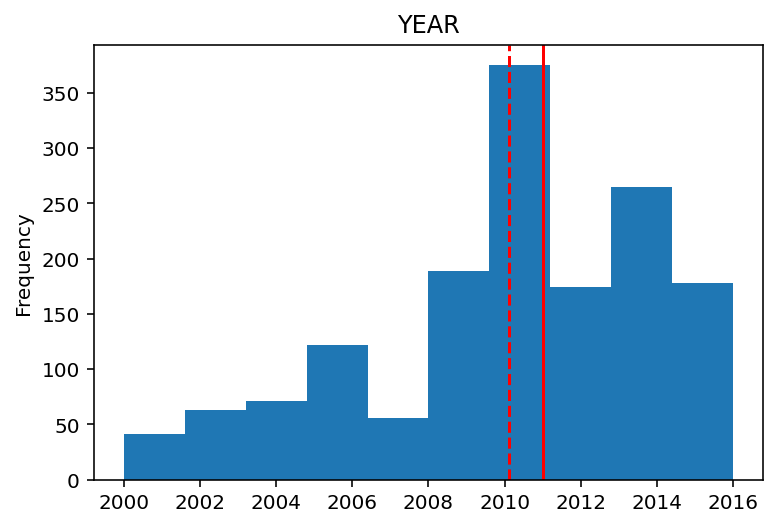

In [75]:
#The distribution of year is skewed to the left with a clear mode at 2010
col = 'YEAR'
hist = df[col].plot(kind = 'hist', title = col)
hist.axvline(np.mean(df[col]), color='r', linestyle='--')
hist.axvline(np.median(df[col]), color='r', linestyle='-')

The distribution of month appears to be bimodal with most outage occuring around January and December as well as around June and July. I considered January and December to be next to eachother because this is ordinal data values. We can assume that this is because of uncontrollable outages, such as winter and summer storms and rain. The mean value is somewhere directly in the middle of summer. 

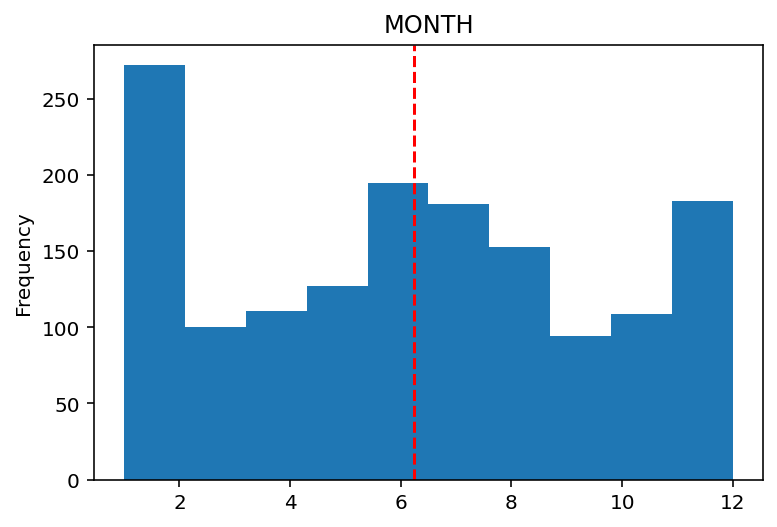

In [76]:
col = 'MONTH'
hist = df[col].plot(kind = 'hist', title = col)
hist.axvline(np.mean(df[col]), color='r', linestyle='--')
hist.axvline(np.median(df[col]), color='r', linestyle='-')

We can also look at the outage duration column to see how long outages usually are, and if there are any major power outage durations. As seen below, the bowplot does have a lot of outliers, most likely the result of drastic/severe reasons. This means the data skews right with a mode at 0. We can plot the histograms without the outliers to see a better distribution of the data. Normally, the outage durations are not that long, with longer durations having fewer occurances. 

<AxesSubplot:title={'center':'OUTAGE.DURATION'}>

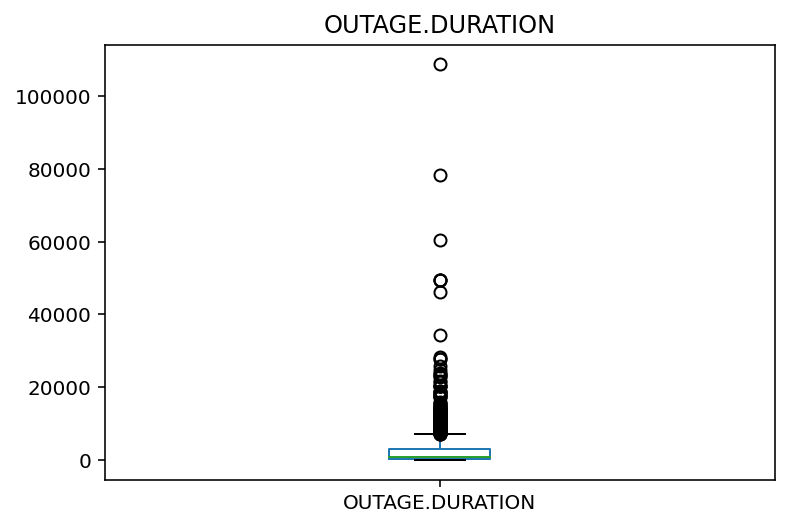

In [77]:
#Distribution of outage duration very skewed to right with mode at 0. Likely a result of some outages just not being solved for a variety of drastic reasons
col = 'OUTAGE.DURATION'
df[col].plot(kind = 'box', title = col)

<AxesSubplot:title={'center':'OUTAGE.DURATION'}, ylabel='Frequency'>

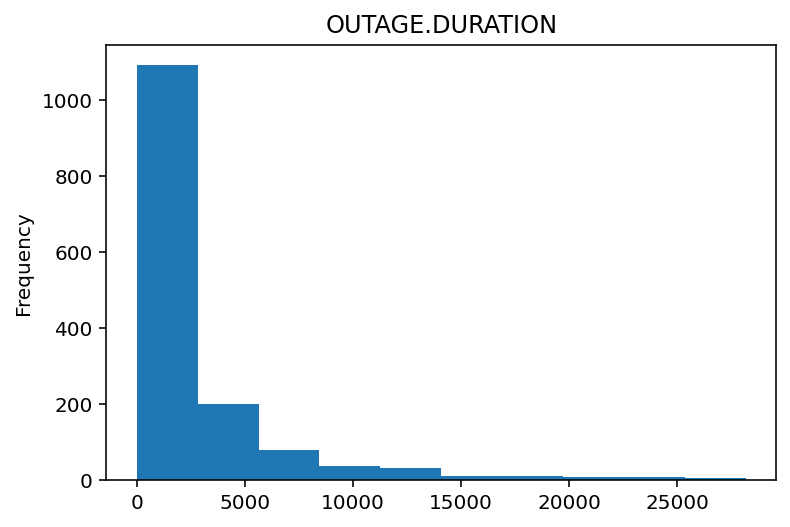

In [78]:
df[df[col] < 30000][col].plot(kind = 'hist', title = col)

<AxesSubplot:title={'center':'OUTAGE.DURATION'}, ylabel='Frequency'>

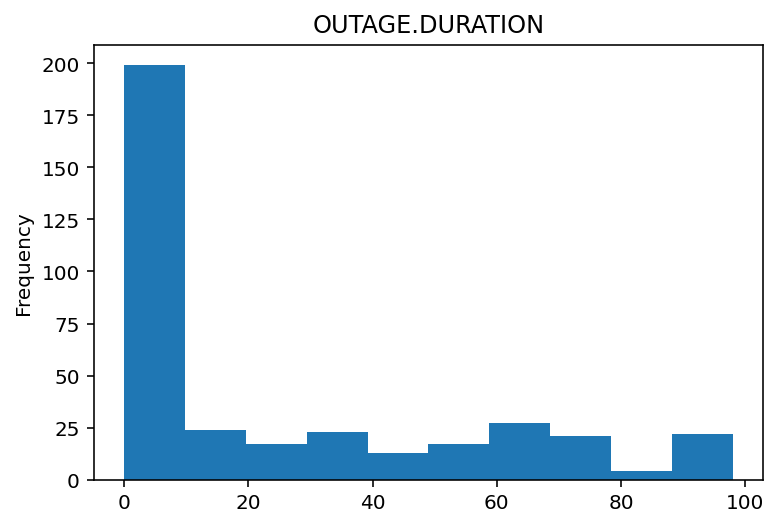

In [79]:
df[df[col] < 100][col].plot(kind = 'hist', title = col)

We can also look at populations that are affected, or, rather, how many people are affected by these outages. In the boxplot below, we can see a lot of outliers, meaning mass power outages are less common. We can plot a histogram without these outliers for a better idea of the distribution. This is skewed right.

<AxesSubplot:title={'center':'CUSTOMERS.AFFECTED'}>

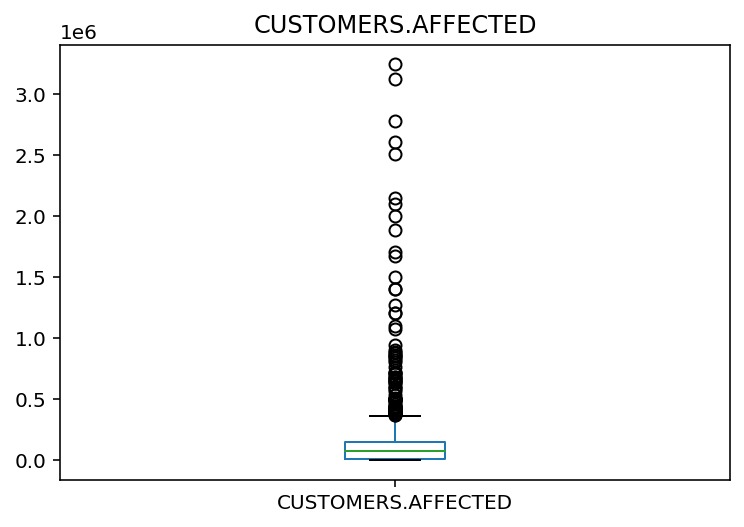

In [80]:
#Skewed to right with mode at 0
col = 'CUSTOMERS.AFFECTED'
df[col].plot(kind = 'box', title = col)

<AxesSubplot:title={'center':'CUSTOMERS.AFFECTED'}, ylabel='Frequency'>

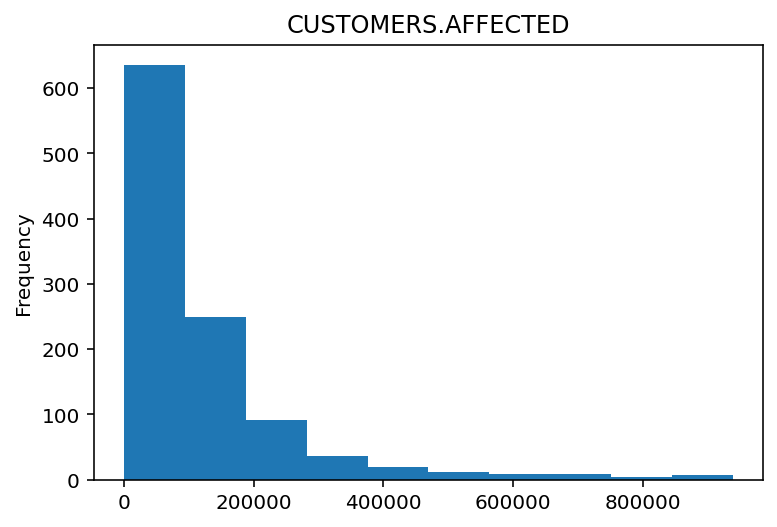

In [81]:
df[df[col] < 1000000][col].plot(kind = 'hist', title = col)

Lets start with some simple visualizations of the data. First, we want to see how many outages are occuring by state in this dataset. We can create a dataframe containing just the data we need: state codes and count of outages. Next, we can use the folium package to plot an interactive map of the United States and color code the percent of outages. We can see that states like California, Texas, Washington, and New York have a lot more outages than other states. We can plot population to see if this is related. We can begin by seeing what timeframe this dataset covers using groupby.

In [82]:
df.groupby('YEAR').count().index

Float64Index([2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0,
              2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0,
              2016.0],
             dtype='float64', name='YEAR')

In [83]:
#Create a dataframe with state codes and count of outages
def create_state_count_df(df):
    #gets counts per state
    state_num_outages = df.groupby('POSTAL.CODE').count()['OUTAGE.START']
    #gets state codes
    states = state_num_outages.index.values
    #gets num outages
    num_outages = state_num_outages.values
    #creates empty df
    dff = pd.DataFrame()
    #assigns state colm to state codes
    dff['States'] = states
    #assigns num outages colm to number outages
    dff['Num Outages'] = num_outages
    return dff

#FOLIUM GRAPHS 
def plot_state_count(dff):
    #creates a map 
    m = folium.Map(location=[48, -102], zoom_start=3)
    #for state codes
    url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
    state_geo = f'{url}/us-states.json'
    #creates the map
    folium.Choropleth(
        geo_data = state_geo,
        name='choropleth',
        data=dff,
        columns=['States','Num Outages'],
        key_on='feature.id',
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Number of Outages from 2000 to 2016'
    ).add_to(m)
    folium.LayerControl().add_to(m)
    return m
plot_state_count(create_state_count_df(df))

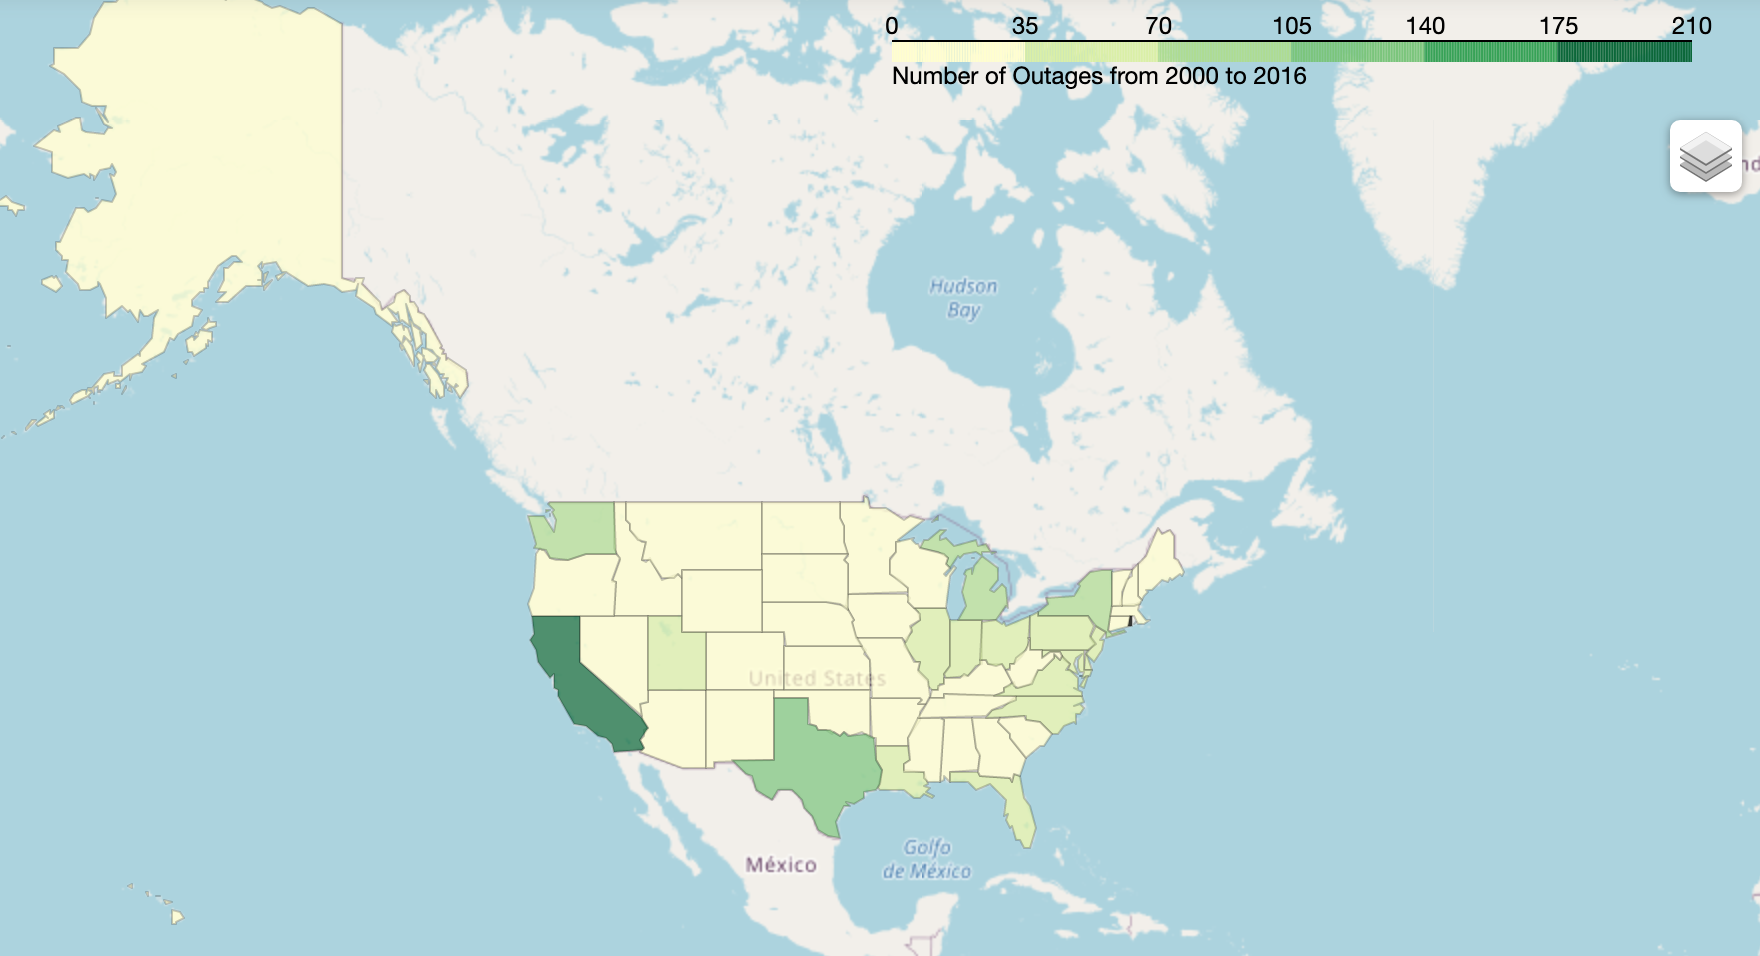

In [94]:
Image(filename='num_outages.png') 

Below, we calculate the mean population for a state since there are many years included in the dataframe. This way, we get a rough estimate of the population. As expected, the most populated areas are the places with the most outages. However, there are some outliers to this, such as Louisiana, Colorado, Georgia, and Indiana. 

In [84]:
#Create a dataframe with state codes and population
def create_pop_df(df):
    #grabs the columns we need
    a = df[['POPULATION','POSTAL.CODE']]
    #converts population to int
    a['POPULATION'] = a['POPULATION'].astype(int)
    #makes a groupby table of the mean population for a certain state over a time period
    b = a.groupby('POSTAL.CODE').mean()
    #grabs the states
    states = b.index.values
    #gets mean population
    population = b.values
    #creates empty df
    dff = pd.DataFrame()
    #assigns state colm to state codes
    dff['States'] = states
    #assigns population colm to number population
    dff['Population'] = population
    return dff

def plot_state_pop(dff):
    #creates a map 
    m = folium.Map(location=[48, -102], zoom_start=3)
    #for state codes
    url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
    state_geo = f'{url}/us-states.json'
    #creates the map
    folium.Choropleth(
        geo_data = state_geo,
        name='choropleth',
        data=dff,
        columns=['States','Population'],
        key_on='feature.id',
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Average Population from 2000 to 2016'
    ).add_to(m)
    folium.LayerControl().add_to(m)
    return m
plot_state_pop(create_pop_df(df))

/Users/emilyramond/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


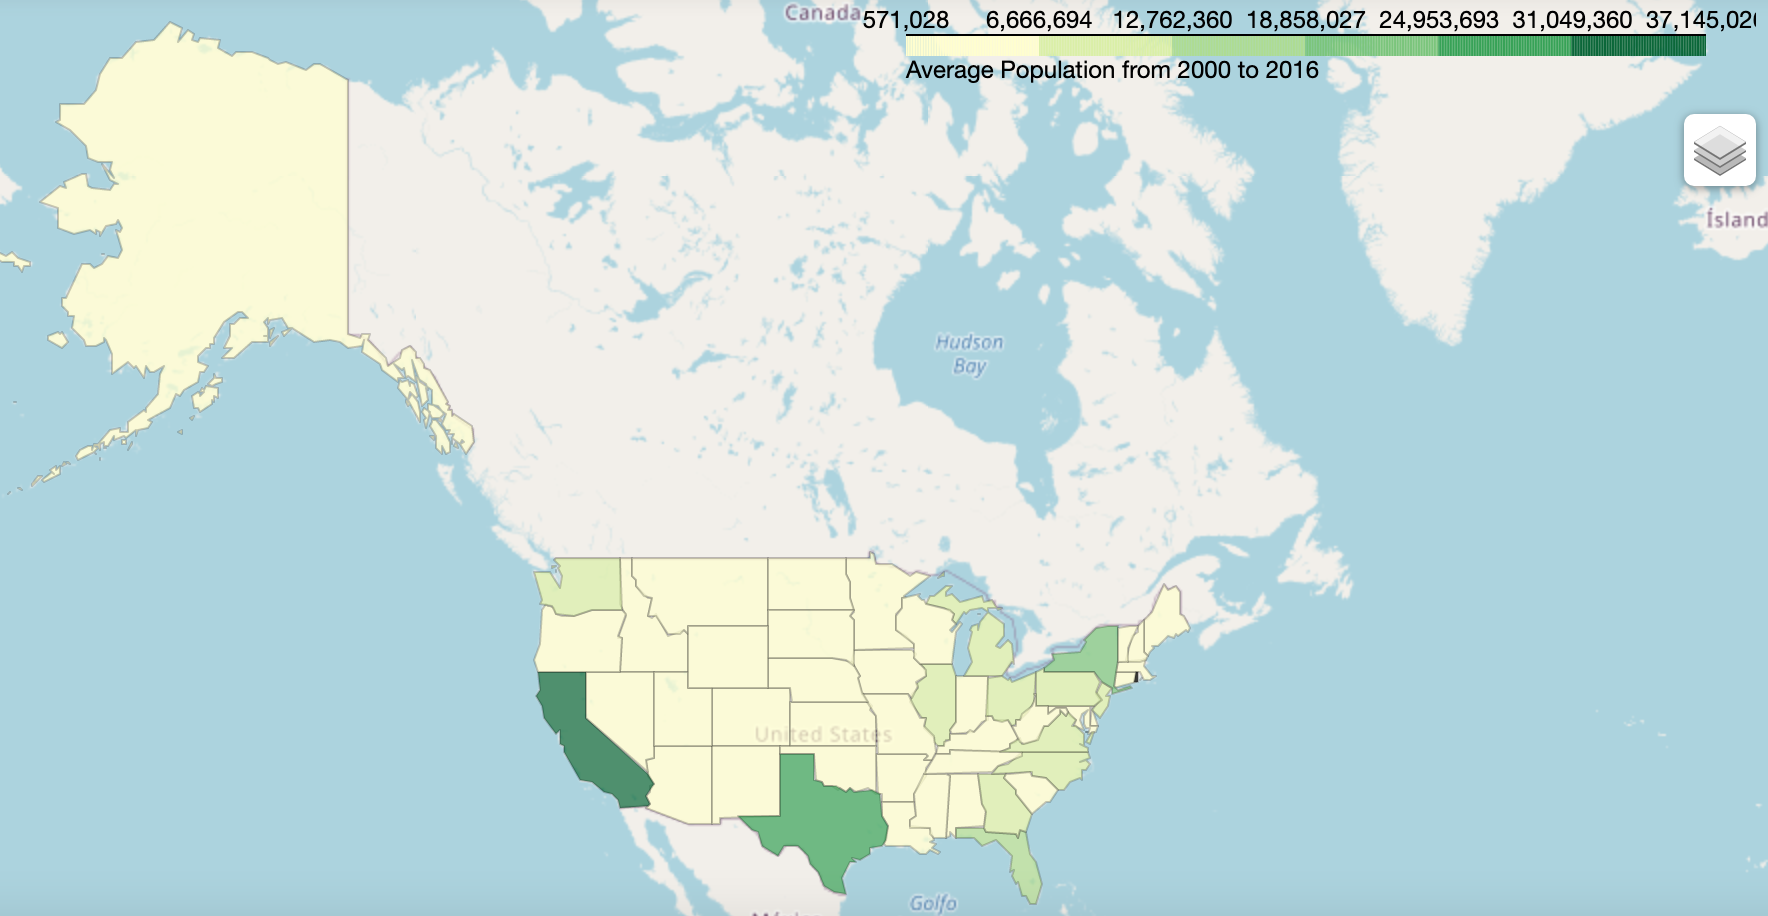

In [96]:
Image(filename='avg_pop.png') 

Now we would like to see if California has the most mean total outage time, due to it having the most power outages. Remember, just because California has the most population and outage reports, does not mean it suffers the most from total outage time. So, we should plot this to visualize it! 
When running the code, we find that Wisconsin (as well as West Virginia!), not California, suffers the most from total outage time. We can run a hypothesis test to confirm that Wisconsin, on average, has a longer mean outage time than other states. 

In [85]:
#Create a dataframe with state codes and population
def create_pop_df(df):
    #grabs the columns we need
    a = df[['OUTAGE.TIME','POSTAL.CODE']]
    #converts outage time to timedeltas, filling NaT values with 0, and converting to hours
    a['OUTAGE.TIME'] = df['OUTAGE.TIME'].fillna(pd.Timedelta(0)).astype('timedelta64[h]')
    #makes a groupby table of the mean outage time for a certain state over a time period
    b = a.groupby('POSTAL.CODE').mean()
    #grabs the states
    states = b.index.values
    #gets mean outage time
    outage_time = b.values
    #creates empty df
    dff = pd.DataFrame()
    #assigns state colm to state codes
    dff['States'] = states
    #assigns outage time colm to number population
    dff['Outage Time'] = outage_time
    return dff

def plot_state_pop(dff):
    #creates a map 
    m = folium.Map(location=[48, -102], zoom_start=3)
    #for state codes
    url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
    state_geo = f'{url}/us-states.json'
    #creates the map
    folium.Choropleth(
        geo_data = state_geo,
        name='choropleth',
        data=dff,
        columns=['States','Outage Time'],
        key_on='feature.id',
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Mean Total Outage Time from 2000 to 2016'
    ).add_to(m)
    folium.LayerControl().add_to(m)
    return m
plot_state_pop(create_pop_df(df))

/Users/emilyramond/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


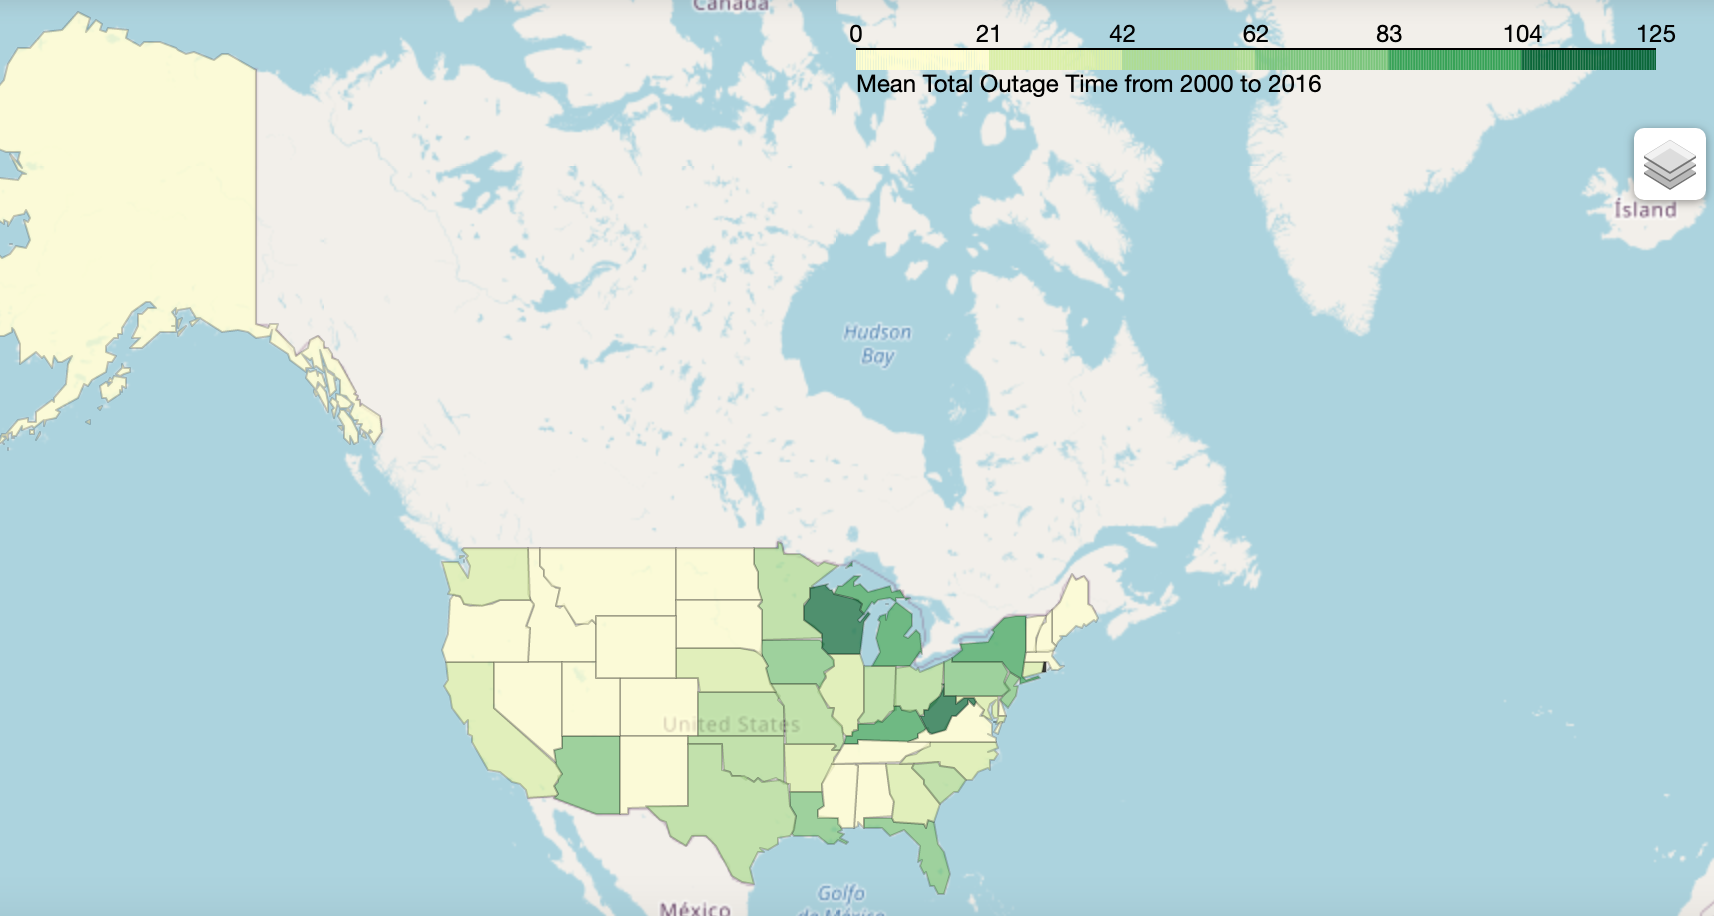

In [97]:
Image(filename='mean_outage_time.png') 

Lets explore something different. Lets look at the most common category, then at the most common category detail to get a little more information! 

In [86]:
cause_categories = df.groupby('CAUSE.CATEGORY').count().index
cause_categories_d = df.groupby('CAUSE.CATEGORY.DETAIL').count().index
strn = "Cause Categories\n"+str(cause_categories)+ "\n\nDetailed Categories\n"+str(cause_categories_d)
print(strn)

Cause Categories
Index(['equipment failure', 'fuel supply emergency', 'intentional attack',
       'islanding', 'public appeal', 'severe weather',
       'system operability disruption'],
      dtype='object', name='CAUSE.CATEGORY')

Detailed Categories
Index([' Coal', ' Hydro', ' Natural Gas', '100 MW loadshed', 'Coal',
       'HVSubstation interruption', 'Hydro', 'Petroleum', 'breaker trip',
       'cables', 'computer hardware', 'distribution interruption',
       'earthquake', 'failure', 'feeder shutdown', 'flooding', 'fog',
       'generator trip', 'hailstorm', 'heatwave', 'heavy wind', 'hurricanes',
       'lightning', 'line fault', 'majorsystem interruption', 'plant trip',
       'public appeal', 'relaying malfunction', 'sabotage', 'shed load',
       'snow/ice ', 'snow/ice storm', 'storm', 'substation',
       'suspicious activity', 'switching', 'thunderstorm',
       'thunderstorm; islanding', 'tornadoes', 'transformer outage',
       'transmission', 'transmission interruption'

In [87]:
cause_tbl = df[['CAUSE.CATEGORY','U.S._STATE']].pivot_table(index = 'CAUSE.CATEGORY', columns = 'U.S._STATE', aggfunc ='size').fillna(value=0)
cause_tbl

U.S._STATE,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
CAUSE.CATEGORY,,,,,,,,,,,,,,,,,,,,,
equipment failure,0.0,1.0,4.0,1.0,21.0,0.0,0.0,1.0,1.0,4.0,...,0.0,2.0,6.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
fuel supply emergency,0.0,0.0,0.0,0.0,17.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0
intentional attack,1.0,0.0,18.0,6.0,24.0,5.0,8.0,37.0,0.0,2.0,...,0.0,8.0,13.0,35.0,9.0,1.0,64.0,1.0,7.0,3.0
islanding,0.0,0.0,0.0,1.0,28.0,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0
public appeal,0.0,0.0,0.0,7.0,9.0,0.0,0.0,0.0,0.0,3.0,...,0.0,1.0,17.0,1.0,0.0,2.0,1.0,0.0,1.0,0.0
severe weather,5.0,0.0,4.0,10.0,70.0,4.0,10.0,2.0,9.0,26.0,...,0.0,20.0,65.0,2.0,0.0,32.0,24.0,3.0,7.0,1.0
system operability disruption,0.0,0.0,2.0,0.0,41.0,4.0,0.0,1.0,0.0,10.0,...,0.0,3.0,20.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0


We can interpret the above to see why some states have more outages than others. For example California suffers a lot from severe weather and intentional attacks, as well as islanding. Similarly to texas, there is a lot of uncontrollable reasons for outages. We can plot category detail to get more information. For example, Washington suffers more than normal from vandalism. 

In [88]:
cause_detail_tbl = df[['CAUSE.CATEGORY.DETAIL','U.S._STATE']].pivot_table(index = 'CAUSE.CATEGORY.DETAIL', columns = 'U.S._STATE', aggfunc ='size').fillna(value=0)
cause_detail_tbl

U.S._STATE,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Carolina,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
CAUSE.CATEGORY.DETAIL,,,,,,,,,,,,,,,,,,,,,
Coal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
Hydro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Natural Gas,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
100 MW loadshed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Coal,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HVSubstation interruption,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hydro,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Petroleum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
breaker trip,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Assessment of Missingness

In the code below, we run a permutation test to varify if CUSTOMERS.AFFECTED missingness is dependent of the CAUSE.CATEGORY. In other terms, is the number of customers affected missingness dependent on what type of category the outage was? Due to NaN values in the CUSTOMERS.AFFECTED column having a CAUSE.CATEGORY of intentional attack, we expect that there will be a dependance relation, and we set a signifigance level of .05. 

The code below runs takes in a dataframe, a column that CUSTOMERS.AFFECTED could potentially be dependent on, and the number of simulations you would like to run. We use total variation distance as a test statistic due to having a categorical column, and shuffle the column given to see if there is a difference between the observed TVD and simulated TVDs. After calculating these TVDs, we find the pvalue and plot the results in a histogram. 

This histogram shows that the pvalue of 0.0 is never within the same distribution as the shuffled, and is below our .05 signifigance level. This means that the missingness of CUSTOMERS.AFFECTED is directly dependent on CAUSE.CATEGORY, just as we predicted. 

0.0

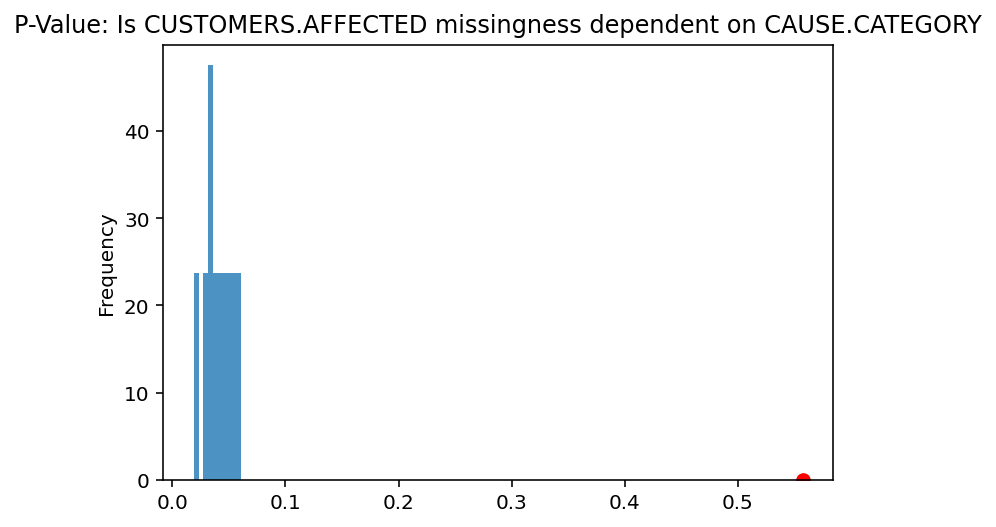

In [89]:
import matplotlib.pyplot as plt

#TEST FOR DEPENDENCE 
def perm4missing(df, col, N):
    
    dist = df.assign(is_null = df['CUSTOMERS.AFFECTED'].isnull()).pivot_table(index = 'is_null', columns = col, aggfunc='size').apply(lambda x:x/x.sum(), axis=1)
    #dist.T.plot(kind='bar') 
    
    tvds = [] #tvds array
    
    #simulations
    for _ in range(N):
        
        #shuffle the col column
        shuffled_col = df[col].sample(replace=False, frac=1).reset_index(drop=True)
        
        #put into a new table with shuffled values
        shuffled = df.assign(**{col: shuffled_col, 'is_null':df['CUSTOMERS.AFFECTED'].isnull()})
        
        #compute TVD
        shuffled = shuffled.pivot_table(index='is_null', columns = col, aggfunc='size').apply(lambda x:x/x.sum(), axis=1)
        #shuffled.T.plot(kind='bar')
        tvd=shuffled.diff().iloc[-1].abs().sum()/2
        
        #append to array 
        tvds.append(tvd)
    
    #calculate observed value 
    obs = dist.diff().iloc[-1].abs().sum()/2
    
    #calculate pvalue
    pval = np.mean(tvds >= obs)
    
    #VISUALIZE P VALUE
    plot = pd.Series(tvds).plot(kind='hist', density=True, alpha=.8, title = 'P-Value: Is CUSTOMERS.AFFECTED missingness dependent on CAUSE.CATEGORY')
    plot2 = plt.scatter(obs, 0, color='red', s=40)
    return pval
perm4missing(df, 'CAUSE.CATEGORY', 10)
#We get a pvalue of 0.0, because CUSTOMERS.AFFECTED IS dependent on CAUSE.CATEGORY!


In the code below, we run a permutation test to varify if ANOMALY.LEVEL missingness is dependent of the U.S._STATE that the outage occured in. This means that we are checking if the index for El Nino is missing more in specific US States. By examining these columns, there seems to be no correlation between missingness of El Nino index and the specific US State, but we can run a permutation test to check this. 

The code below runs takes in a dataframe, a column that ANOMALY.LEVEL could potentially be dependent on, and the number of simulations you would like to run. We use total variation distance as a test statistic due to having a categorical column, and shuffle the column given to see if there is a difference between the observed TVD and simulated TVDs. After calculating these TVDs, we find the pvalue and plot the results in a histogram. 

This histogram shows that the pvalue of .49 is a very reasonable value and the missingness is not dependent on US State, which is exactly what we predicted. This means that when randomly shuffled, the TVD is usually the same, and there is no dependance relation. 

0.53

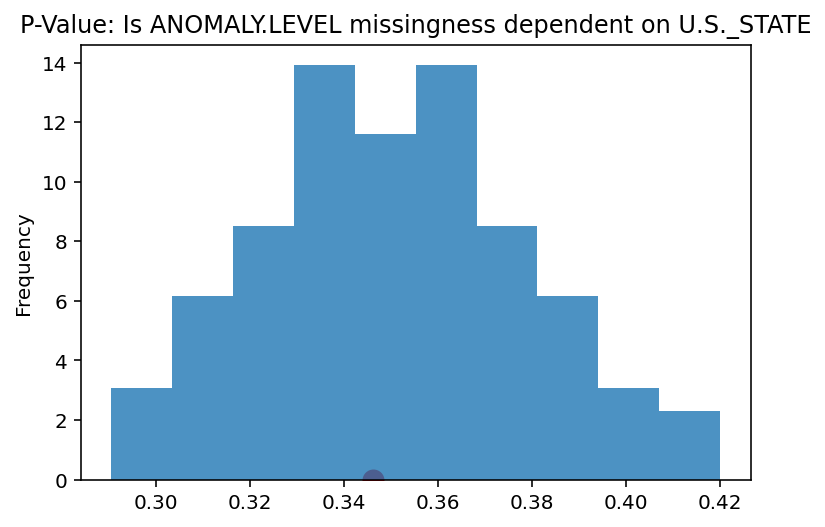

In [90]:
#CHECK FOR NO DEPDENDENCE
def perm4missing2(df, col, N):
    dist = df.assign(is_null = df['ANOMALY.LEVEL'].isnull()).pivot_table(index = 'is_null', columns = col, aggfunc='size').apply(lambda x:x/x.sum(), axis=1)
    #dist.T.plot(kind='bar') 
    
    tvds = [] #tvds array
    
    #simulations
    for _ in range(N):
        
        #shuffle the col column
        shuffled_col = df[col].sample(replace=False, frac=1).reset_index(drop=True)
        
        #put into a new table with shuffled values
        shuffled = df.assign(**{col: shuffled_col, 'is_null':df['ANOMALY.LEVEL'].isnull()})
        
        #compute TVD
        shuffled = shuffled.pivot_table(index='is_null', columns = col, aggfunc='size').apply(lambda x:x/x.sum(), axis=1)
        #shuffled.T.plot(kind='bar')
        tvd=shuffled.diff().iloc[-1].abs().sum()/2
        
        #append to array 
        tvds.append(tvd)
    
    #calculate observed value 
    obs = dist.diff().iloc[-1].abs().sum()/2
    
    #calculate pvalue
    pval = np.mean(tvds >= obs)
    
    #VISUALIZE PVALUE 
    plot2 = plt.scatter(obs,0,color='red', s=100)
    plot = pd.Series(tvds).plot(kind='hist', density=True, alpha=.8, title = 'P-Value: Is ANOMALY.LEVEL missingness dependent on U.S._STATE')
   
    return pval

perm4missing2(df, 'U.S._STATE', 100)

### Hypothesis Test

Now we want to answer a question: Does wisconsin have a longer outage time than other states on average? In order to do this, we are going to run a hypothesis test to see if Wisconsin, on average, has a longer average total time outage than other states, meaning they come from different distributions. Our test statistic is the mean total outage time. We will set a signifigance level of .05.  

The null hypothesis: Wisconsin, on average, has the same mean total time outages as other states. 
The alternate hypothesis: Wisconsin, on average, has more mean total time outages than other states. 

After running the simulation 1000 times, we get a pvalue of .007, meaning we reject the null hypothesis, and confirm that Wisconsin has more mean total time outages than other states. We plot the histogram for a visualization of where our pvalue lays and how many times, by chance, we get a distribution more extreme, which is rarely. Thus, we reject the null hypothesis. 

0.006

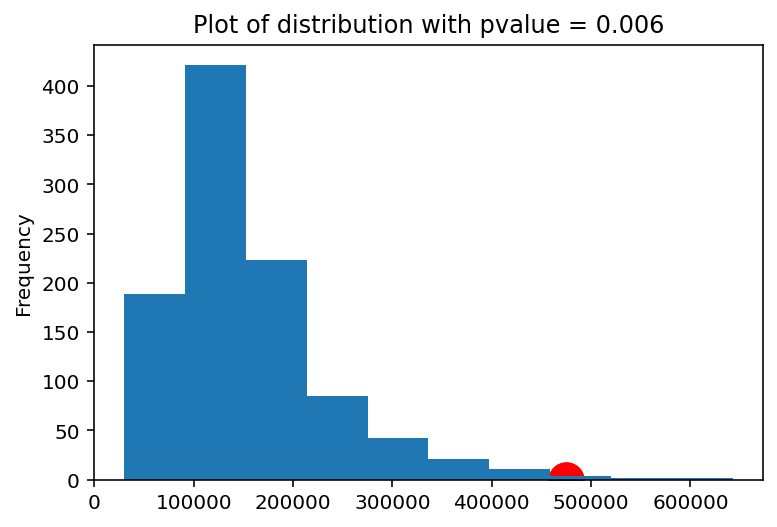

In [91]:
def sim_pvalue(df, n = 1000):
    #FIND OBSERVED VALUE
    #Grab the columns we need
    state_df = df[['U.S._STATE','OUTAGE.TIME']]
    #Divide state averages to find the mean average time
    state_avgs = state_df.groupby('U.S._STATE').sum()['OUTAGE.TIME'].divide(df[['U.S._STATE','OUTAGE.TIME']].groupby('U.S._STATE').count()['OUTAGE.TIME'])
    #Set our observed statistic to the mean outage time in Wisconsin
    obs = state_avgs.loc['Wisconsin']
    
    #SIMULATE ONE TEST STATISTIC
    def sim_avg(df):
        '''helper function that simulates a test statistic which is the mean time for wisconsin power outages.'''
        #Grab how many samples we should take 
        num_wis_outages = int(df.groupby('U.S._STATE').size().loc['Wisconsin'])
        #Sample from the dataframe
        sample = df.sample(num_wis_outages,replace = True)
        #Sum the total outage time and divide by number of outages
        out = sample['OUTAGE.TIME'].sum() 
        return out / num_wis_outages
    #Array for test statistics
    avgs = []
    for i in range(n):
        #Simulate n amount of test statistics
        avgs.append(sim_avg(state_df))
        
    #Calculate pvalue
    p_value = np.count_nonzero(np.array(avgs) >= obs) / n
    #Graphs a histogram of the seconds
    pd.Series(avgs).astype('timedelta64[s]').plot.hist(title = 'Plot of distribution with pvalue = '+str(p_value), density=False)
    #Adds a point for the observed value
    plt.scatter(obs.total_seconds(), 0, color='red', s=300)
    return p_value
sim_pvalue(df)